In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

import numpy as np

from nonlocalgames.hamiltonians import G14
from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz
from nonlocalgames.measurement import MeasurementLayer

In [3]:
def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        '++++',
        [qubits] * players,
        adapt_order=False,
        min_theta = 1e-4)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    constrained = False
    if 'constrained' in path:
        constrained = True

    if 'metadata' in data:
        layer = data['metadata'].get('layer', 'ry')
        constrained = data['metadata'].get('constrain_phi', constrained)
    else:
        layer = 'ry'
    
    ml = MeasurementLayer.get(layer, players=2, questions=14, qubits=2)
    
    if constrained:
        if phi.ndim == 1:
            phi = np.concatenate([phi, phi]).reshape(ml.shape)
        else:
            phi = np.concatenate([phi, phi])
            assert phi.shape == ml.shape
    
    ml.params = phi

    if constrained:
        ml.conj(1)

    return qc, ml

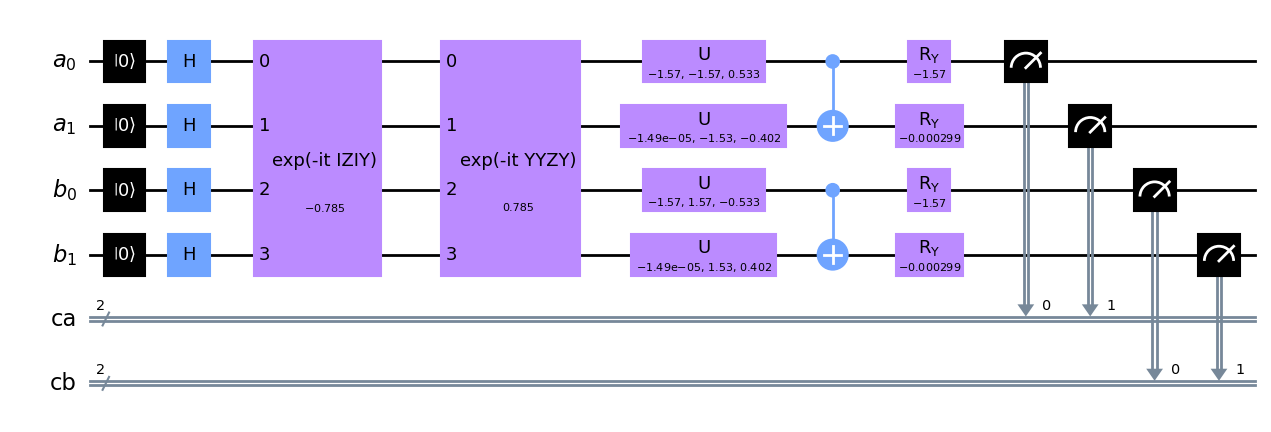

In [7]:
# Prepare nonlocal game circuit for G14
questions = G14.get_questions()
qc, ml = load_g14_circuit('../data/g14_constrained_u3ry/g14_state.json')
nlg = NLGCircuit(qc, None, measurement_layer=ml)

circuits = {
    q: nlg._prepare_question(q) for q in questions
}
circuits[(0, 0)].draw('mpl')

In [8]:
for (va, vb), circ in circuits.items():
    with open(f'../circuits/g14_{va}_{vb}.qasm', 'w') as f:
        f.write(circ.qasm())